In [1]:
import pandas as pd
import json
import numpy as np
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('pdf', fonttype=42)
matplotlib.rc('ps', fonttype=42)

import os
sns.set(font_scale=1.25, style='whitegrid')
sns.set(palette='magma')

figdir = '../paper/'


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations
from scipy.stats import friedmanchisquare

from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import os
from glob import glob

print('figdir:',figdir)

def save(name='tmp',h=None):
    name = name.strip().replace(' ','-').replace('%','pct')
    if h == None:
        h = plt.gcf()
    h.tight_layout()
    print('saving',figdir+'/'+name+'.pdf')
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    plt.savefig(figdir+'/'+name+'.pdf', bbox_inches='tight')
    
from cd_diagram import draw_cd_diagram

figdir: ../paper/


In [2]:
df_sum = pd.read_csv('../results/results_black-box_summary.csv.gz',
                     compression='gzip')

df_sum

,algorithm,dataset,random_state,training time (s),mse_test,mae_test,r2_test,model_size,training time (hr),r2_zero_test,...,r2_test_rank,r2_test_norm,model_size_rank,model_size_norm,r2_zero_test_rank,r2_zero_test_norm,rmse_test_rank,rmse_test_norm,log_mse_test_rank,log_mse_test_norm
0,AFP,1027_ESL,13879.5,1210.966865,0.365049,0.442612,0.830930,20.5,0.336380,0.830930,...,19.0,0.963934,11.0,0.000770,19.0,0.952298,19.0,0.084952,19.0,0.075793
1,AFP,1028_SWD,13879.5,3017.658321,0.438023,0.538419,0.314517,47.0,0.838238,0.314517,...,19.0,0.933128,15.0,0.000378,19.0,0.795878,22.0,0.082426,22.0,0.076834
2,AFP,1029_LEV,13879.5,2622.206193,0.433124,0.508817,0.521904,23.5,0.728391,0.521904,...,19.0,0.987051,12.5,0.000229,19.0,0.934869,18.0,0.025763,18.0,0.024398
3,AFP,1030_ERA,13879.5,3007.024177,2.496171,1.299746,0.358716,36.5,0.835284,0.358716,...,19.0,0.978802,16.0,0.003315,19.0,0.917586,17.0,0.022299,17.5,0.026826
4,AFP,1089_USCrime,13879.5,590.939726,549.423049,18.823004,0.639671,25.0,0.164150,0.639671,...,21.0,0.822717,13.0,0.001007,21.0,0.780937,19.0,0.200320,19.0,0.286474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3396,uDSR,687_sleuth_ex1605,16322.5,467.736557,136.690742,9.560274,0.186892,16.0,0.129927,0.186892,...,17.0,0.993926,9.0,0.000238,17.0,0.389935,17.0,0.022411,17.0,0.073335
3397,uDSR,690_visualizing_galaxy,16322.5,380.951180,676.721353,21.075751,0.920812,11.5,0.105820,0.920812,...,23.5,0.914433,2.0,0.000025,23.5,0.910024,23.0,0.192018,23.0,0.345208
3398,uDSR,695_chatfield_4,16322.5,223.893122,307.115915,12.377622,0.832787,6.0,0.062193,0.832787,...,13.5,0.996855,4.5,0.000023,13.5,0.962087,9.0,0.009832,9.0,0.035854
3399,uDSR,706_sleuth_case1202,16322.5,344.079375,3582.665264,41.594337,0.628823,10.5,0.095578,0.628823,...,4.0,0.998603,6.0,0.000523,4.0,0.945908,10.0,0.018314,10.0,0.057651


In [3]:
df_results = pd.read_feather('../results/black-box_results.feather')

# # Brush results
# df_results_brush = pd.read_feather('../results/black-box_results_brush.feather')
# df_results = pd.concat([df_results_brush, df_results], axis=0)

# df_results_brush = pd.read_feather('../results/black-box_results_C_D_UCB1.feather')
# df_results = pd.concat([df_results_brush, df_results], axis=0)

# combine with local results ---------------------------------
df_results_local = pd.read_feather('../results/black-box_results_local.feather')
df_results = pd.concat([df_results_local, df_results], axis=0)

# removing feat (it was a sanity check)
# df_results = df_results.loc[df_results['algorithm']!='FEAT(e-lex)']

# Removing mislabeled datasets (these are clf, but PMLB v1.0 had it as regr)
df_results = df_results[ ~df_results["dataset"].isin(["banana", "titanic"]) ]

df_results = df_results[ df_results["algorithm"].isin([
    "D-TS",
    "D-UCB1",
    "C-D-TS",
    "C-D-UCB1",
    "Baseline",
    # "FEAT(e-lex)",
    # 'FEAT SD-Split',
    # 'FEAT S-Split',
    # 'FEAT D-Split',
    # "NeSymRes 10M",
    # "NeSymRes 100M",
]) ]


print('mean trial count:')
print(df_results.groupby('algorithm')['dataset'].count().sort_values()
      / df_results.dataset.nunique())

df_results2 = df_results.merge(df_results.groupby('dataset')['algorithm'].nunique().reset_index(),
                              on='dataset',suffixes=('','_count'))

                                       
# rankings per trial per dataset
for col in [c for c in df_results2.columns if c.endswith('test') or c.endswith('size')]:
    ascending = 'r2' not in col
    df_results2[col+'_rank_per_trial']=df_results2.groupby(['dataset','random_state'])[col].apply(lambda x: 
                                                                              round(x,3).rank(
                                                                              ascending=ascending))
    
df_sum = df_results2.groupby(['algorithm','dataset'],as_index=False).median()
df_sum['rmse_test'] = df_sum['mse_test'].apply(np.sqrt)
df_sum['log_mse_test'] = df_sum['mse_test'].apply(lambda x: np.log(1+x))
df_results = df_results2

# rankings and normalized scores per dataset
for col in [c for c in df_sum.columns if c.endswith('test') or c.endswith('size')]:
    ascending = 'r2' not in col
    df_sum[col+'_rank']=df_sum.groupby(['dataset'])[col].apply(lambda x: 
                                                                        round(x,3).rank(ascending=ascending)
                                                                  )
    df_sum[col+'_norm'] = df_sum.groupby('dataset')[col].apply(lambda x: (x-x.min())/(x.max()-x.min()))
    

mean trial count:
algorithm
Baseline    9.942623
C-D-UCB1    9.959016
D-UCB1      9.959016
C-D-TS      9.967213
D-TS        9.967213
Name: dataset, dtype: float64


In [4]:
brushes = ['Baseline',
    "C-D-UCB1",
    "C-D-TS",
    "D-UCB1",
    "D-TS"]

results_df = df_sum[df_sum["algorithm"].isin(brushes)]
results_df

,algorithm,dataset,random_state,training time (s),mse_test,mae_test,r2_test,model_size,training time (hr),r2_zero_test,...,r2_test_rank,r2_test_norm,model_size_rank,model_size_norm,r2_zero_test_rank,r2_zero_test_norm,rmse_test_rank,rmse_test_norm,log_mse_test_rank,log_mse_test_norm
0,Baseline,1027_ESL,16322.5,98.844428,0.285341,0.397526,0.842603,12.5,0.027457,0.842603,...,5.0,0.000000,1.0,0.000000,5.0,0.000000,3.0,0.710108,3.0,0.707909
1,Baseline,1028_SWD,16322.5,184.855799,0.406259,0.508071,0.380959,32.0,0.051349,0.380959,...,2.0,0.778391,2.0,0.260870,2.0,0.778391,3.0,0.415400,3.0,0.413976
2,Baseline,1029_LEV,16322.5,138.588144,0.415108,0.490326,0.539893,22.5,0.038497,0.539893,...,4.0,0.158371,5.0,1.000000,4.0,0.158371,2.5,0.137488,2.5,0.136755
3,Baseline,1030_ERA,16322.5,145.253823,2.453457,1.250093,0.361832,18.5,0.040348,0.361832,...,4.0,0.489928,3.5,0.225806,4.0,0.489928,1.0,0.000000,1.0,0.000000
4,Baseline,1089_USCrime,16322.5,91.788254,445.863392,16.049091,0.672110,10.5,0.025497,0.672110,...,4.0,0.468963,4.0,0.692308,4.0,0.468963,3.0,0.291673,3.0,0.313123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,D-UCB1,695_chatfield_4,16322.5,245.263870,296.504811,12.149087,0.846151,9.5,0.068129,0.846151,...,3.0,0.626352,2.5,0.642857,3.0,0.626352,3.0,0.200875,3.0,0.208981
606,D-UCB1,706_sleuth_case1202,16322.5,181.369499,3801.848642,44.873196,0.590896,13.0,0.050380,0.590896,...,3.0,0.692179,4.5,1.000000,3.0,0.692179,3.0,0.281057,3.0,0.287792
607,D-UCB1,712_chscase_geyser1,16322.5,200.626909,43.430949,5.363643,0.726520,7.5,0.055730,0.726520,...,5.0,0.000000,2.0,0.111111,5.0,0.000000,3.0,0.336582,3.0,0.338556
608,D-UCB1,nikuradse_1,16322.5,200.272836,0.000367,0.015081,0.984726,45.0,0.055631,0.984726,...,1.0,1.000000,5.0,1.000000,1.0,1.000000,1.0,0.000000,1.0,0.000000


In [5]:
results_df.columns

Index(['algorithm', 'dataset', 'random_state', 'training time (s)', 'mse_test',
       'mae_test', 'r2_test', 'model_size', 'training time (hr)',
       'r2_zero_test', 'friedman_dataset', 'symbolic_alg', 'algorithm_count',
       'mse_test_rank_per_trial', 'mae_test_rank_per_trial',
       'r2_test_rank_per_trial', 'model_size_rank_per_trial',
       'r2_zero_test_rank_per_trial', 'rmse_test', 'log_mse_test',
       'mse_test_rank', 'mse_test_norm', 'mae_test_rank', 'mae_test_norm',
       'r2_test_rank', 'r2_test_norm', 'model_size_rank', 'model_size_norm',
       'r2_zero_test_rank', 'r2_zero_test_norm', 'rmse_test_rank',
       'rmse_test_norm', 'log_mse_test_rank', 'log_mse_test_norm'],
      dtype='object')

In [6]:
boxplot_kwargs = { # Standarized boxplot style
    'kind'        : "box",
    'dodge'       : False,
    'showfliers'  : False,                 
    'flierprops'  : {"marker": "x"},
    'notch'       : True,
    'orient'      : "v",
    'estimator'   : np.median, 
    'boxprops'    : {"facecolor": 'white'},
    'medianprops' : {"color": "k", "linewidth": 3},
    'showcaps'    : False,
}

order = [
    "Baseline",
    "D-UCB1", "C-D-UCB1",
    "D-TS", "C-D-TS",
]

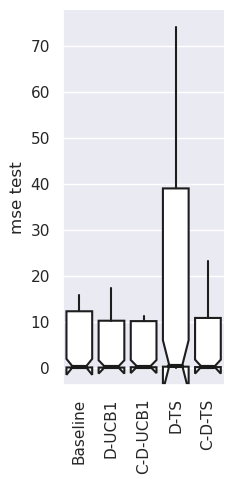

,classifier_name,dataset_name,accuracy
148,C-D-TS,294_satellite_image_16322.5,1.141106


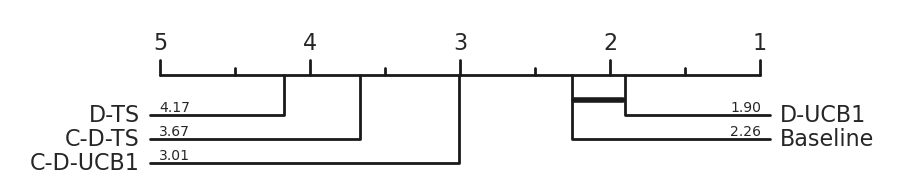

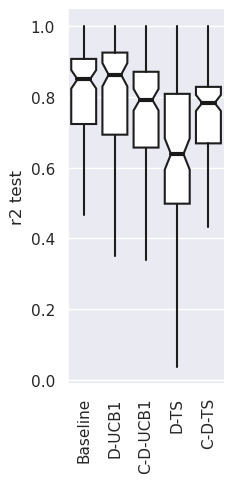

,classifier_name,dataset_name,accuracy
205,C-D-TS,621_fri_c0_100_10_16322.5,0.672387


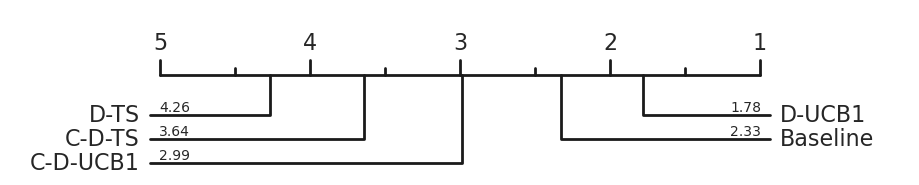

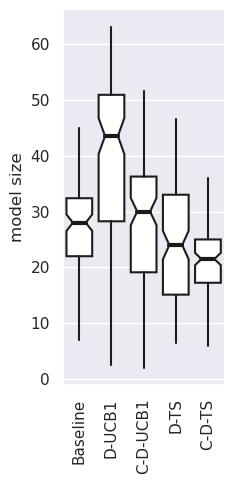

,classifier_name,dataset_name,accuracy
51,Baseline,583_fri_c1_1000_50_16322.5,29.0


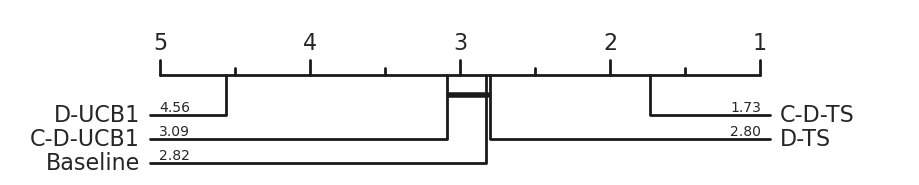

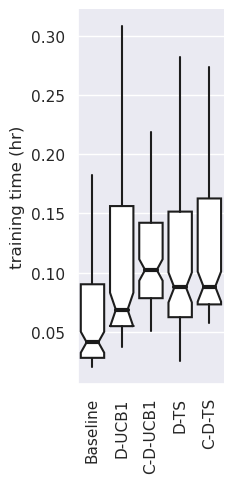

,classifier_name,dataset_name,accuracy
319,C-D-UCB1,611_fri_c3_100_5_16322.5,0.093275


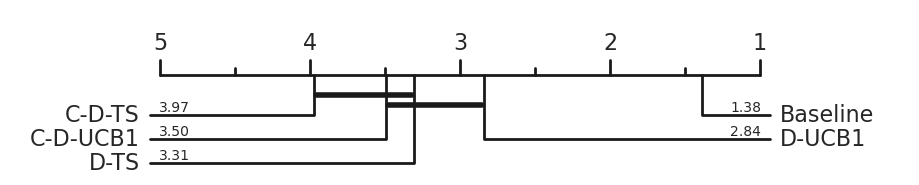

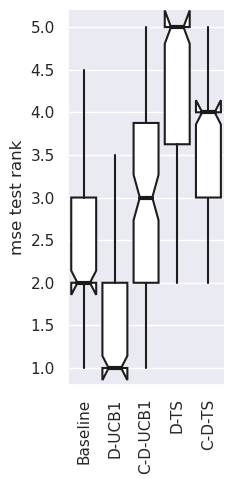

,classifier_name,dataset_name,accuracy
372,D-TS,1191_BNG_pbc_16322.5,5.0


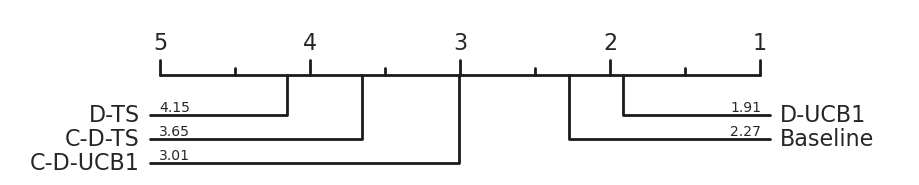

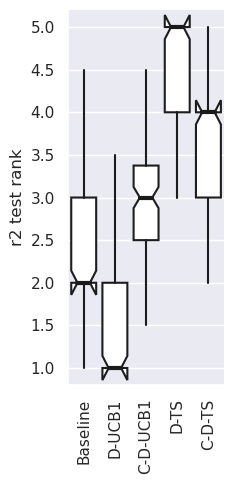

,classifier_name,dataset_name,accuracy
16,Baseline,201_pol_16322.5,3.0


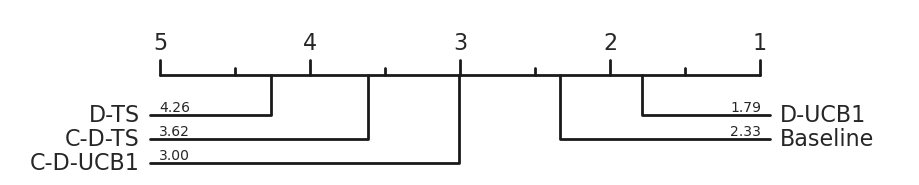

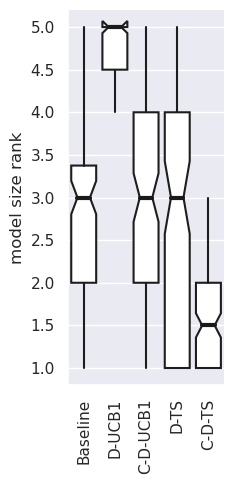

,classifier_name,dataset_name,accuracy
421,D-TS,589_fri_c2_1000_25_16322.5,1.0


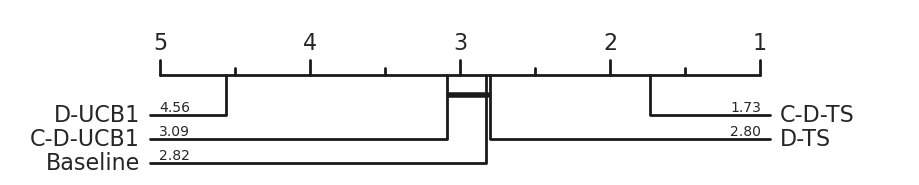

In [7]:
results_df['contextual'] = results_df['algorithm'].apply(lambda model: model.startswith("C-"))
            
for yaxis in ['mse_test', 'r2_test', 'model_size', 'training time (hr)',
              'mse_test_rank', 'r2_test_rank', 'model_size_rank']:
    # Exploring boxplot results first
    g = sns.catplot(data=results_df, x='algorithm', y=yaxis, hue='contextual',
        #col='dataset', col_wrap=4,
        order=order,
        facet_kws={'sharey': False, 'sharex': False, 'legend_out':False}, 
        **boxplot_kwargs,
        sharey=False, legend_out=False, aspect=0.5)

    g.set_titles("{col_name}").set_axis_labels("", yaxis.replace("_", " "))
    hatches = ['///', 'xxx']

    plt.xticks(rotation=90)
    #g.set(yscale="log")

    g._legend.remove()
    plt.tight_layout()
    plt.savefig(f"../paper/boxplot_{yaxis}.pdf")
    plt.show()  
    
    cd_df = results_df.copy()#.dropna() # (Just Island model sometimes gives an NAN)
    
    # Dropping seeds where we have less results (so we can run the critical diagram)
    less_than_max = cd_df['random_state'].value_counts().lt(
                                    cd_df['random_state'].value_counts().max())
    less_than_max_values = less_than_max[less_than_max].index.tolist()
    cd_df = cd_df[~cd_df['random_state'].isin(less_than_max_values)]
    
    less_than_max = cd_df['dataset'].value_counts().lt(
                                    cd_df['dataset'].value_counts().max())
    less_than_max_values = less_than_max[less_than_max].index.tolist()
    cd_df = cd_df[~cd_df['dataset'].isin(less_than_max_values)]

    # Line below controls if we take the median or use each random seed as a different problem in CD
    # cd_df = cd_df.groupby(['algorithm', 'dataset']).median().reset_index()
    
    cd_df = cd_df[cd_df.algorithm.isin(brushes)]
    cd_df['dataset_random_state'] = cd_df['dataset'] + '_' + cd_df['random_state'].astype(str)

    cd_df = cd_df[['algorithm', 'dataset_random_state', yaxis]]
    display(cd_df.pivot('dataset_random_state', 'algorithm').sample(3).style.background_gradient(cmap='viridis_r', axis=1))
    
    cd_df.columns = ['classifier_name', 'dataset_name', 'accuracy']
    display(cd_df.sample())

    if yaxis != 'r2_test': # smaller is better
        cd_df.accuracy = cd_df.accuracy*-1 

    draw_cd_diagram(cd_df, alpha=0.05, path=f"../paper/cd_{yaxis}.pdf")